# Import Data

In [1]:
! pip install pytorch-pretrained-bert pytorch-nlp

# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

!pip install scikit-plot
import scikitplot as skplt
import sklearn
from sklearn.metrics import accuracy_score, f1_score,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

     |████████████████████████████████| 133kB 5.6MB/s 
     |████████████████████████████████| 92kB 5.1MB/s 
     |████████████████████████████████| 133kB 6.9MB/s 
     |████████████████████████████████| 71kB 5.5MB/s 
     |████████████████████████████████| 6.9MB 7.2MB/s 
ERROR: botocore 1.19.25 has requirement urllib3<1.27,>=1.25.4; python_version != "3.4", but you'll have urllib3 1.24.3 which is incompatible.


In [2]:
FOMC_df = pd.read_csv('/content/sample_data/data_for_colab.csv')

In [3]:
# FOMC_df.set_index('document_data_512', inplace=True)
FOMC_df.head()

,FOMC_date,document_type,document_data_512,document_data_wo_stopwords_512,press_conference,release_date,label_market,label_FED,label_LM,label_LM_512
0,2006-01-31,minutes,account messrs oliner and slifman associate di...,messrs moskow poole hoenig alternate members F...,0,2006-02-21,1,1,0,1
1,2006-01-31,statement,for immediate release share the FOMC decided t...,immediate release share FOMC decided today rai...,0,2006-01-31,1,1,2,2
2,2000-10-03,statement,utilization of the pool of available workers r...,immediate release FOMC meeting today decided m...,0,2000-10-03,0,2,2,1
3,2000-10-03,minutes,indexes of stock market prices declined somewh...,though previous policy tightening actions yet ...,0,2000-11-16,0,2,0,0
4,2000-03-21,statement,growth and of the information currently availa...,raise target federal funds rate 25 basis point...,0,2000-03-21,0,2,0,1


In [4]:
print('Market Label Counts')
print(FOMC_df["label_market"].value_counts())

print('Fed Label Counts')
print(FOMC_df["label_FED"].value_counts())

Market Label Counts
1    255
0    125
2     20
Name: label_market, dtype: int64
Fed Label Counts
2    167
0    125
1    108
Name: label_FED, dtype: int64


#### Weight Train/Test Data by Number of Labels

In [5]:
X_train, X_val, y_train, y_val = train_test_split(
    FOMC_df["document_data_wo_stopwords_512"].values, 
    FOMC_df['label_market'].values,
    test_size=.20,
    stratify=FOMC_df['label_market'].values
)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(320,)
(320,)
(80,)
(80,)


In [6]:
print('Train Market Label Counts')
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

print('Test Market Label Counts')
unique, counts = np.unique(y_val, return_counts=True)
print(dict(zip(unique, counts)))


Train Market Label Counts
{0: 100, 1: 204, 2: 16}
Test Market Label Counts
{0: 25, 1: 51, 2: 4}


In [ ]:
# FOMC_df['data_type'] = ['not_set']*FOMC_df.shape[0]
# FOMC_df.loc[X_train,'data_type'] = 'train'
# FOMC_df.loc[X_val, 'data_type'] = 'val'
# FOMC_df.groupby(['label_market', 'data_type'])

# FOMC_df[FOMC_df['data_type'] =='train']['document_data_wo_stopwords_512'].values

## BERT Tokenizer


In [ ]:
!pip install transformers
# !pip install --upgrade transformers
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

In [8]:
#load BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)

In [10]:
# Create a function to tokenize a set of texts
def preprocessing_for_bert(doc_data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for data in doc_data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_data = tokenizer.encode_plus(
            text=data,  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=512,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_data.get('input_ids'))
        attention_masks.append(encoded_data.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [11]:
# Run function `preprocessing_for_bert` on the train set and the validation set
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


## Create DataLoader

In [33]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size 32.
batch_size = 4#16#32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(
    train_data, 
    sampler=train_sampler, 
    batch_size=batch_size
)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(
    val_data, 
    sampler=val_sampler, 
    batch_size=batch_size
)

## Create BERT Pretrained Model

In [13]:
from transformers import BertForSequenceClassification

In [14]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = 3,
    output_attentions = False,
    output_hidden_states = False
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

## Setup Optimizer & Scheduler

In [15]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [34]:
optimizer = AdamW(
    model.parameters(),
    lr=1e-5,
    eps=1e-8
)

epochs = 10

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = len(train_dataloader) * epochs
)

## Performance Metrics & Functions

In [17]:
from sklearn.metrics import f1_score

In [18]:
def calc_f1_score(predictions, labels):
  preds = np.argmax(predictions, axis=1).flatten
  labels_flatten = labels.flatten

  return f1_score(labels_flatten, preds, average='weighted')

In [19]:
def calc_accuracy_per_class(predictions, labels):
  preds = np.argmax(predictions, axis=1).flatten
  labels_flatten = labels.flatten

  labels_actual = ['Negative', "Neutral", "Postive"]
  idx = 2
  
  for label in np.unique(labels_flatten):
    y_preds = preds[labels_flatten == label]
    y_true = labels_flatten[labels_flatten == label]
    print(f'Class: {labels_actual[idx]}')
    print(f'Accuracy: {len(y_preds[y_preds == label])/len(y_true)}')

    idx -= 1

In [20]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

cuda


In [35]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in tqdm(dataloader_val):
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals


In [39]:
# # print(train_dataloader)
# epochs = 1
# for epoch in tqdm(range(1, epochs+1)): 
#     model.train()
    
#     loss_train_total = 0
    
#     progress_bar = tqdm(train_dataloader, 
#                         desc = 'Epoch {:1d}'.format(epoch),
#                         leave=False,
#                         disable=False                       
#                        )
#     for batch in progress_bar:
#         model.zero_grad()
#         batch = tuple(b.to(device) for b in batch)
        
#         inputs = {
#             'input_ids' : batch[0],
#             'attention_mask' : batch[1],
#             'labels' : batch[2]
#         }
#         outputs = model(**inputs)
        
#         loss = outputs[0]
#         loss_train_total += loss.item()        
#         loss.backward()
        
#         torch.nn.utils.clip_grad_norm(model.parameters(), 1.0)
        
#         optimizer.step()
#         scheduler.step()
        
#         progress_bar.setpostfix('training_loss: {:.3f}'.format(loss.item()))
        
#         torch.save(model.state_dict(), f'/content/sample_data/BERT_ft_epoch{epoch}.model')
        
#         tqdm.white(f'\nEpoch {epoch}')
#         loss_train_avg = loss_train_total/len(dataloader)
#         tqdm.write(f'Traininge loss: {loss_train_avg}')
        
#         val_loss, predictions, true_vals = evaluate(dataloader_val)
#         val_f1 = f1_score_func(preditions, true_vals)
        
#         tqdm.write(f'Validation Loss: {val_loss}')
#         tqdm.write(f'F1 Score (weighted): {val_f1}')

In [41]:
import random
import time
import torch.nn as nn

# Specify loss function
loss_fn = nn.CrossEntropyLoss()


def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):

    print("Start training...\n")
    for epoch_i in range(epochs):
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [43]:
train(model, train_dataloader, val_dataloader, epochs=2, evaluation=True)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


RuntimeError: ignored

In [ ]:
encode_data_train = tokenizer.batch_encode_plus(
    FOMC_df[FOMC_df['data_type'] =='train']['document_data_wo_stopwords_512'].values,
    add_special_tokens = True,
    return_attention_mask = True,
    pad_to_max_length = True,
    max_length = 512
)

encode_data_val = tokenizer.batch_encode_plus(
    FOMC_df[FOMC_df['data_type'] =='val']['document_data_wo_stopwords_512'].values,
    add_special_tokens = True,
    return_attention_mask = True,
    pad_to_max_length = True,
    max_length = 512
)

input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_masks']
labels_train = torch.tensor(FOMC_df[FOMC_df['data_type'] =='train']['label_market'].values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_masks']
labels_val = torch.tensor(FOMC_df[FOMC_df['data_type'] =='val']['label_market'].values)


KeyError: ignored

In [ ]:
# FOMC_df = FOMC_df.drop_duplicates()
FOMC_minute_df = FOMC_df[FOMC_df['document_type'] == 'minutes']
FOMC_statement_df = FOMC_df[FOMC_df['document_type'] == 'statement']

In [ ]:
# FOMC_model_data_df = FOMC_df[['document_data', 'score_LM']]
FOMC_model_data_df = FOMC_df[['document_data_512', 'label_market']]
FOMC_wo_stopwords_model_data_df = FOMC_df[['document_data_wo_stopwords_512', 'label_market']]
FOMC_model_data_df.head()

,document_data_512,label_market
0,account messrs oliner and slifman associate di...,1
1,for immediate release share the FOMC decided t...,1
2,utilization of the pool of available workers r...,0
3,indexes of stock market prices declined somewh...,0
4,growth and of the information currently availa...,0


In [ ]:
FOMC_df['label_market'].value_counts()

1    255
0    125
2     20
Name: label_market, dtype: int64

### Function to Convert Label Into to Label String

In [ ]:
def label_to_string(label_int):
    label_string = 'neutral'
    if label_int == 0:
        label_string = 'negative'
    elif label_int == 2:
        label_string = 'positive'
    return label_string
    
FOMC_df['str_label_market'] = FOMC_df['label_market'].apply(lambda score: label_to_string(score))
FOMC_df['str_label_FED'] = FOMC_df['label_FED'].apply(lambda score: label_to_string(score))
FOMC_df['str_label_LM'] = FOMC_df['label_LM'].apply(lambda score: label_to_string(score))
FOMC_df['str_label_LM_512'] = FOMC_df['label_LM_512'].apply(lambda score: label_to_string(score))


# Pretrained FinBERT Model

In [ ]:
## Load required packages
!pip install torch torchvision
!pip install transformers
!pip install torch==1.7.0 -f https://download.pytorch.org/whl/torch_stable.html

from transformers import AutoTokenizer, AutoModelForSequenceClassification

Looking in links: https://download.pytorch.org/whl/torch_stable.html


### Download Pretrained FinBERT Model

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("ipuneetrathore/bert-base-cased-finetuned-finBERT")
model = AutoModelForSequenceClassification.from_pretrained("ipuneetrathore/bert-base-cased-finetuned-finBERT")

In [ ]:
def finBERTModelPreTrained(review_text):
    MAX_LEN = 512
    class_names = ['negative', 'neutral', 'positive']

    encoded_new = tokenizer.encode_plus(
                            review_text,                      # Sentence to encode.
                            add_special_tokens = True,        # Add '[CLS]' and '[SEP]'
                            max_length = MAX_LEN,             # Pad & truncate all sentences.
                            padding = 'longest',
                            truncation=True,
                            return_attention_mask = True,     # Construct attn. masks.
                            return_tensors = 'pt',            # Return pytorch tensors.
                       )

    # Add the encoded sentence to the list.    
    input_idst = (encoded_new['input_ids'])
    attention_maskst = (encoded_new['attention_mask'])

    # Convert the lists into tensors.
    input_idst = torch.cat([input_idst], dim=0)
    attention_maskst = torch.cat([attention_maskst], dim=0)

    new_test_output = model(input_idst, token_type_ids=None, 
                          attention_mask=attention_maskst)

    logits = new_test_output[0]
    predicted = logits.detach().numpy()

    # Store predictions
    flat_predictions = np.concatenate(predicted, axis=0)

    # For each sample, pick the label (0 or 1) with the higher score.
    new_predictions = np.argmax(flat_predictions).flatten()

    # return class_names[new_predictions[0]]
    return new_predictions[0]


### FinBERT Pretrained Score on Data

In [ ]:
FOMC_df['label_PT_FinBERT_512'] = FOMC_df['document_data_512'].apply(lambda data: finBERTModelPreTrained(data))



In [ ]:
FOMC_df['str_label_PT_FinBERT_512'] = FOMC_df['label_PT_FinBERT_512'].apply(lambda score: label_to_string(score))

Pretrained FinBERT Label Counts for Middle 512 Words
document_type  str_label_PT_FinBERT_512
minutes        positive                    109
               neutral                      74
               negative                     34
statement      neutral                     126
               positive                     51
               negative                      6
Name: str_label_PT_FinBERT_512, dtype: int64

-----------------------------------------------------



Text(0.5, 1.0, 'Pretrained FinBERT Label Counts for Middle 512 Words\nby Document Type')

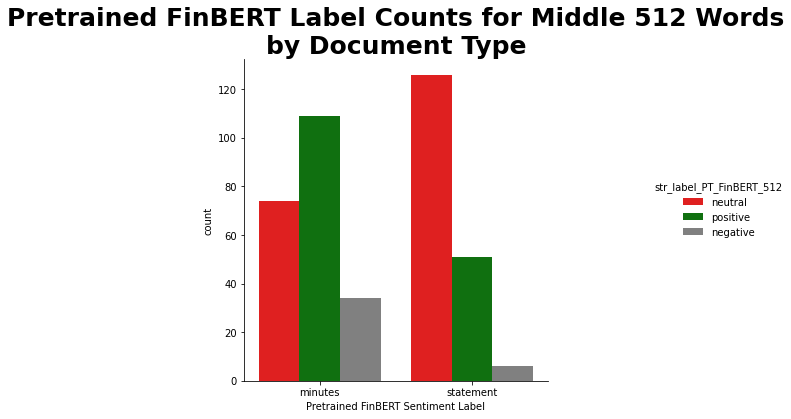

In [ ]:
print("Pretrained FinBERT Label Counts for Middle 512 Words")
print(FOMC_df.groupby('document_type')['str_label_PT_FinBERT_512'].value_counts())
print('\n-----------------------------------------------------\n')

ax = sns.catplot(data=FOMC_df, x='document_type', hue='str_label_PT_FinBERT_512', kind='count', palette=['red','green','gray'])
plt.xlabel('Pretrained FinBERT Sentiment Label')
plt.title('Pretrained FinBERT Label Counts for Middle 512 Words\nby Document Type', fontweight='bold', fontsize = 25)

### FinBERT Pretrained Score on Data WITHOUT Stop Words

In [ ]:
FOMC_df['label_PT_FinBERT_512woStopWords'] = FOMC_df['document_data_wo_stopwords_512'].apply(lambda data: finBERTModelPreTrained(data))


In [ ]:
FOMC_df['str_label_PT_FinBERT_512woStopWords'] = FOMC_df['label_PT_FinBERT_512woStopWords'].apply(lambda score: label_to_string(score))

Pretrained FinBERT Label Counts for Middle 512 Words without Stop Words
document_type  str_label_PT_FinBERT_512woStopWords
minutes        neutral                                154
               positive                                54
               negative                                 9
statement      neutral                                157
               positive                                23
               negative                                 3
Name: str_label_PT_FinBERT_512woStopWords, dtype: int64

-----------------------------------------------------



Text(0.5, 1.0, 'Pretrained FinBERT Label Counts for Middle 512 Words\nWithout Stop Words by Document Type')

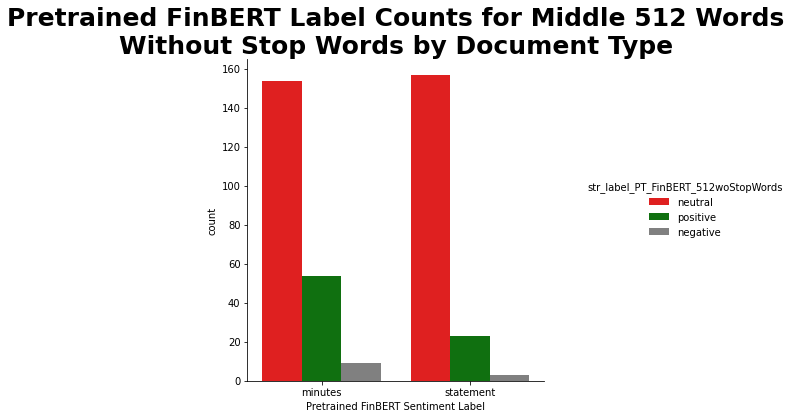

In [ ]:
print("Pretrained FinBERT Label Counts for Middle 512 Words without Stop Words")
print(FOMC_df.groupby('document_type')['str_label_PT_FinBERT_512woStopWords'].value_counts())
print('\n-----------------------------------------------------\n')

ax = sns.catplot(data=FOMC_df, x='document_type', hue='str_label_PT_FinBERT_512woStopWords', kind='count', palette=['red','green','gray'])
plt.xlabel('Pretrained FinBERT Sentiment Label')
plt.title('Pretrained FinBERT Label Counts for Middle 512 Words\nWithout Stop Words by Document Type', fontweight='bold', fontsize = 25)

### FinBERT Confusion Matrixes & Correlations

#### FinBERT vs Market Label

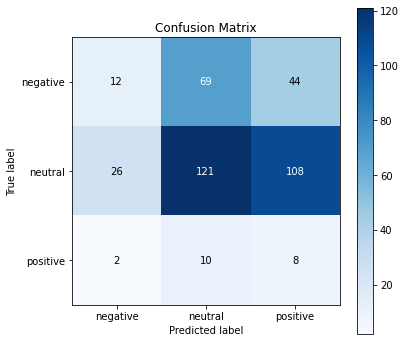

In [ ]:
true_label = FOMC_df['str_label_market']
predicted_label = FOMC_df['str_label_PT_FinBERT_512']
skplt.metrics.plot_confusion_matrix(true_label, predicted_label, figsize=(6,6))

In [ ]:
data_label_market = FOMC_df['str_label_market'].astype('category').cat.codes
predicted_label_FinBERT = FOMC_df['str_label_PT_FinBERT_512'].astype('category').cat.codes

correlation = data_label_market.corr(predicted_label_FinBERT) 

print("All FOMC Documents")
print('Correlation Between Market Label and Pretrained FinBERT Label')
print(correlation)

All FOMC Documents
Correlation Between Market Label and Pretrained FinBERT Label
0.03963121315307703


#### FinBERT without Stop Words vs Market Label

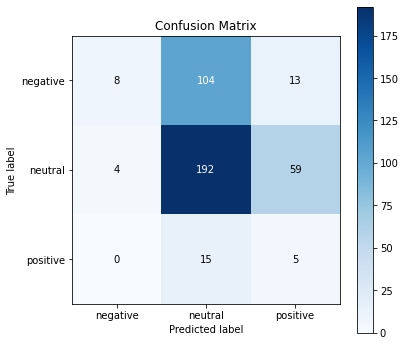

In [ ]:
true_label = FOMC_df['str_label_market']
predicted_label = FOMC_df['str_label_PT_FinBERT_512woStopWords']
skplt.metrics.plot_confusion_matrix(true_label, predicted_label, figsize=(6,6))

In [ ]:
data_label_market = FOMC_df['str_label_market'].astype('category').cat.codes
predicted_label_FinBERT = FOMC_df['str_label_PT_FinBERT_512woStopWords'].astype('category').cat.codes

correlation = data_label_market.corr(predicted_label_FinBERT) 

print("All FOMC Documents")
print('Correlation Between Market Label and Pretrained FinBERT Label without Stop Words')
print(correlation)

All FOMC Documents
Correlation Between Market Label and Pretrained FinBERT Label without Stop Words
0.17777774538413943


##### Minute Data Only

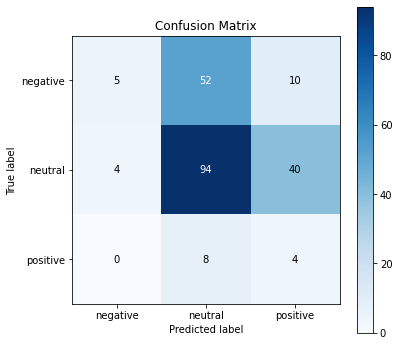

In [ ]:
FOMC_minutes_df = FOMC_df[FOMC_df['document_type'] == 'minutes']
true_label = FOMC_minutes_df['str_label_market']
predicted_label = FOMC_minutes_df['str_label_PT_FinBERT_512woStopWords']
skplt.metrics.plot_confusion_matrix(true_label, predicted_label, figsize=(6,6))

In [ ]:
data_label_market = FOMC_minutes_df['str_label_market'].astype('category').cat.codes
predicted_label_FinBERT = FOMC_minutes_df['str_label_PT_FinBERT_512woStopWords'].astype('category').cat.codes

correlation = data_label_market.corr(predicted_label_FinBERT) 

print("All FOMC Documents")
print('Correlation Between Market Label and Pretrained FinBERT Label without Stop Words')
print(correlation)

All FOMC Documents
Correlation Between Market Label and Pretrained FinBERT Label without Stop Words
0.1760957829861422


# Create Train and Test Data

In [ ]:
from sklearn.model_selection import train_test_split

X = FOMC_model_data_df['document_data']
# y = FOMC_model_data_df['score_LM']
y = FOMC_model_data_df['score_FED']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2020)


In [ ]:
print('X_train.shape',X_train.shape)
print('X_val.shape',X_val.shape)
print('y_train.shape',y_train.shape)
print('y_val.shape',y_val.shape)

# BERT Model

## Data Processing

In [ ]:
!pip install transformers

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
MAX_LEN = 512

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=sent,  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [ ]:
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel

In [ ]:
# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

## Using Kaggle
https://www.kaggle.com/adarshbiradar/sentiment-analysis-using-bert

In [ ]:
from sklearn.model_selection import train_test_split
!pip install simpletransformers
from simpletransformers.classification import ClassificationModel, ClassificationArgs

### 1.1 BERT Models WITH Stop Words

In [ ]:
# FOMC_model_data_df = FOMC_df[['document_data_512', 'label_market']]
# FOMC_wo_stopwords_model_data_df = FOMC_df[['document_data_wo_stopwords_512', 'label_market']]

# FOMC_wo_stopwords_model_data_df = FOMC_df[['document_data_wo_stopwords_512', 'label_market']]

FOMC_model_data_df = FOMC_df[['document_data_512', 'label_market']]
# FOMC_model_data_df = FOMC_df[['document_data_512', 'label_FED']]

train, eva = train_test_split(FOMC_model_data_df, test_size = 0.2)

In [ ]:
print('X_train.shape',train.shape)
print('X_val.shape',eva.shape)
train.head()

X_train.shape (320, 2)
X_val.shape (80, 2)


,document_data_512,label_FED
55,to adjust its plans as appropriate,2
268,rate the FOMC will assess realized and expecte...,2
313,measured by changes in the pce price index was...,1
24,readings from household and business surveys o...,2
317,of energy and other commodities appears to hav...,0


In [ ]:
train_df = pd.DataFrame({
    'text': train['document_data_512'],
    'label': train['label_market']
    # 'label': train['label_FED']

})

eval_df = pd.DataFrame({
    'text': eva['document_data_512'],
    'label': eva['label_market']
    # 'label': eva['label_FED']
})

print(train_df.shape)
print(eval_df.shape)
train_df.head()
# type(train_df)

(320, 2)
(80, 2)


,text,label
55,to adjust its plans as appropriate,2
268,rate the FOMC will assess realized and expecte...,2
313,measured by changes in the pce price index was...,1
24,readings from household and business surveys o...,2
317,of energy and other commodities appears to hav...,0


In [ ]:
print("Pretrained FinBERT Label Counts for Middle 512 Words")
print(eval_df['label'].value_counts())
print('\n-----------------------------------------------------\n')

# ax = sns.catplot(data=FOMC_df, x='document_type', hue='str_label_PT_FinBERT_512', kind='count', palette=['red','green','gray'])
# plt.xlabel('Pretrained FinBERT Sentiment Label')
# plt.title('Pretrained FinBERT Label Counts for Middle 512 Words\nby Document Type', fontweight='bold', fontsize = 25)

Pretrained FinBERT Label Counts for Middle 512 Words
2    31
0    25
1    24
Name: label, dtype: int64

-----------------------------------------------------



#### Create a BERT Model

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
BERT_model = ClassificationModel('bert', 'bert-base-uncased', num_labels=3, args={'reprocess_input_data': True, 'overwrite_output_dir': True},use_cuda=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
BERT_model.train_model(train_df)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:380: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


(40, 1.086297371983528)

In [ ]:
result, model_outputs, wrong_predictions = BERT_model.eval_model(eval_df)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:901: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [ ]:
print(result)
model_outputs[:5]

{'mcc': 0.0, 'eval_loss': 1.0876584112644196}


array([[-0.11877441, -0.31640625,  0.17736816],
       [-0.1965332 , -0.19335938,  0.21813965],
       [-0.21118164, -0.29858398,  0.12609863],
       [-0.13977051, -0.15368652,  0.26806641],
       [-0.19226074, -0.19909668,  0.21704102]])

In [ ]:
true = eval_df['label'].tolist()
predicted = []
for arr in model_outputs:
    predicted.append(np.argmax(arr))

#### BERT Model Results

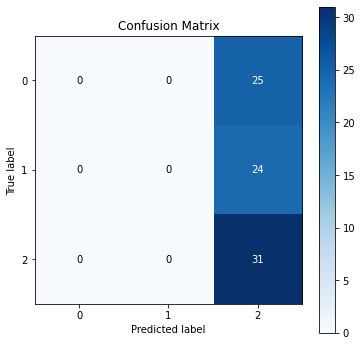

In [ ]:
skplt.metrics.plot_confusion_matrix(true, predicted, figsize=(6,6))

In [ ]:
classification_rep = sklearn.metrics.classification_report(true,predicted,target_names=['negative', 'neutral', 'positive'])
print(classification_rep)

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        25
     neutral       0.00      0.00      0.00        24
    positive       0.39      1.00      0.56        31

    accuracy                           0.39        80
   macro avg       0.13      0.33      0.19        80
weighted avg       0.15      0.39      0.22        80



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 1.2 BERT Models WITHOUT Stop Words

In [ ]:
# FOMC_model_data_df = FOMC_df[['document_data_512', 'label_market']]
FOMC_wo_stopwords_model_data_df = FOMC_df[['document_data_wo_stopwords_512', 'label_market']]

train_wo_sw, eva_wo_sw = train_test_split(FOMC_wo_stopwords_model_data_df, test_size = 0.2)

In [ ]:
print('X_train.shape',train_wo_sw.shape)
print('X_val.shape',eva_wo_sw.shape)
train_wo_sw.head()

X_train.shape (320, 2)
X_val.shape (80, 2)


,document_data_wo_stopwords_512,label_market
302,seen earlier year u financial system appeared ...,1
178,gradual decline unemployment expansion appeare...,1
146,fixed investment advanced housing sector stren...,1
5,nonresidential structures turned last autumn r...,0
336,year despite ongoing adjustment housing sector...,1


In [ ]:
train_wo_sw_df = pd.DataFrame({
    'text': train_wo_sw['document_data_wo_stopwords_512'],
    'label': train_wo_sw['label_market']
})

eva_wo_sw_df = pd.DataFrame({
    'text': eva_wo_sw['document_data_wo_stopwords_512'],
    'label': eva_wo_sw['label_market']
})

print(train_wo_sw_df.shape)
print(eva_wo_sw_df.shape)
train_wo_sw_df.head()

(320, 2)
(80, 2)


,text,label
302,seen earlier year u financial system appeared ...,1
178,gradual decline unemployment expansion appeare...,1
146,fixed investment advanced housing sector stren...,1
5,nonresidential structures turned last autumn r...,0
336,year despite ongoing adjustment housing sector...,1


#### Create a BERT Model

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
BERT_model2 = ClassificationModel('bert', 'bert-base-uncased', num_labels=3, args={'reprocess_input_data': True, 'overwrite_output_dir': True},use_cuda=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
BERT_model2.train_model(train_wo_sw_df)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:380: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


(40, 0.8549266204237937)

In [ ]:
result, model_outputs, wrong_predictions = BERT_model2.eval_model(eva_wo_sw_df)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:901: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [ ]:
print(result)
model_outputs[:5]

{'mcc': 0.0, 'eval_loss': 0.9604218959808349}


array([[ 0.59570312,  1.22167969, -1.69726562],
       [ 0.59082031,  1.23144531, -1.66113281],
       [ 0.51318359,  1.26269531, -1.71679688],
       [ 0.55712891,  1.25878906, -1.69140625],
       [ 0.58496094,  1.20800781, -1.69726562]])

In [ ]:
true = eva_wo_sw_df['label'].tolist()
predicted = []
for arr in model_outputs:
    predicted.append(np.argmax(arr))

#### BERT Model Results

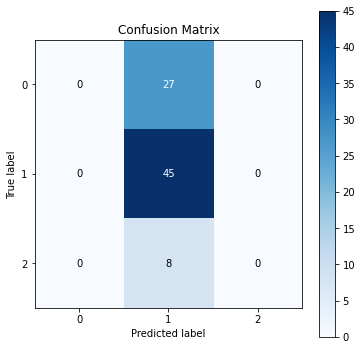

In [ ]:
skplt.metrics.plot_confusion_matrix(true, predicted, figsize=(6,6))

In [ ]:
classification_rep = sklearn.metrics.classification_report(true,predicted,target_names=['negative', 'neutral', 'positive'])
print(classification_rep)

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        27
     neutral       0.56      1.00      0.72        45
    positive       0.00      0.00      0.00         8

    accuracy                           0.56        80
   macro avg       0.19      0.33      0.24        80
weighted avg       0.32      0.56      0.40        80



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 1.3 BERT Models WITHOUT Stop Words - Minutes Only

In [ ]:
FOMC_minutes_df = FOMC_df[FOMC_df['document_type'] == 'minutes']
FOMC_minutes_wo_stopwords_model_data_df = FOMC_minutes_df[['document_data_wo_stopwords_512', 'label_market']]
# FOMC_minutes_wo_stopwords_model_data_df = FOMC_minutes_df[['document_data_wo_stopwords_512', 'label_FED']]



In [ ]:
FOMC_minutes_wo_stopwords_model_data_df.describe

<bound method NDFrame.describe of                         document_data_wo_stopwords_512  label_market
0    messrs moskow poole hoenig alternate members F...             1
3    though previous policy tightening actions yet ...             0
5    nonresidential structures turned last autumn r...             0
7    business outlays nonresidential structures sta...             1
9    eliminated business capital stocks moved close...             1
..                                                 ...           ...
395  tend adjust lag changes short term market inte...             1
396  least members appeared reflect previously post...             1
397  constraint economy however improving balance s...             1
398  slackening world economic expansion conjunctio...             0
399  flow affordability homeownership business spen...             1

[217 rows x 2 columns]>

In [ ]:
train_mins_wo_sw, eva_mins_wo_sw = train_test_split(FOMC_minutes_wo_stopwords_model_data_df, test_size = 0.2)

In [ ]:
print('X_train.shape',train_mins_wo_sw.shape)
print('X_val.shape',eva_mins_wo_sw.shape)
train_mins_wo_sw.head()

X_train.shape (173, 2)
X_val.shape (44, 2)


,document_data_wo_stopwords_512,label_FED
14,business sentiment improvements credit availab...,1
327,major central banks would shift toward accommo...,0
209,line treasuries yields spreads lower tier obli...,0
149,around forecast economic activity similar aver...,2
144,canada suggesting removal policy accommodation...,2


In [ ]:
train_mins_wo_sw_df = pd.DataFrame({
    'text': train_mins_wo_sw['document_data_wo_stopwords_512'],
    'label': train_mins_wo_sw['label_market']
    # 'label': train_mins_wo_sw['label_FED']

})

eva_mins_wo_sw_df = pd.DataFrame({
    'text': eva_mins_wo_sw['document_data_wo_stopwords_512'],
    'label': eva_mins_wo_sw['label_market']
    # 'label': eva_mins_wo_sw['label_FED']
})

print(train_mins_wo_sw_df.shape)
print(eva_mins_wo_sw_df.shape)
train_mins_wo_sw_df.head()

(173, 2)
(44, 2)


,text,label
14,business sentiment improvements credit availab...,1
327,major central banks would shift toward accommo...,0
209,line treasuries yields spreads lower tier obli...,0
149,around forecast economic activity similar aver...,2
144,canada suggesting removal policy accommodation...,2


#### Create a BERT Model - Minutes ONLY

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
BERT_model4 = ClassificationModel('bert', 'bert-base-uncased', num_labels=3, args={'reprocess_input_data': True, 'overwrite_output_dir': True},use_cuda=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
BERT_model4.train_model(train_mins_wo_sw_df)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:380: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


(22, 1.103846243836663)

In [ ]:
result, model_outputs, wrong_predictions = BERT_model4.eval_model(eva_mins_wo_sw_df)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:901: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [ ]:
print(result)
model_outputs[:5]

{'mcc': 0.0, 'eval_loss': 1.0448219180107117}


array([[-0.21972656, -0.4206543 ,  0.08654785],
       [-0.19287109, -0.41625977,  0.08288574],
       [-0.18591309, -0.41967773,  0.05484009],
       [-0.15209961, -0.42529297,  0.06015015],
       [-0.24829102, -0.40942383,  0.05957031]])

In [ ]:
true = eva_mins_wo_sw_df['label'].tolist()
predicted = []
for arr in model_outputs:
    predicted.append(np.argmax(arr))

#### BERT Model Results

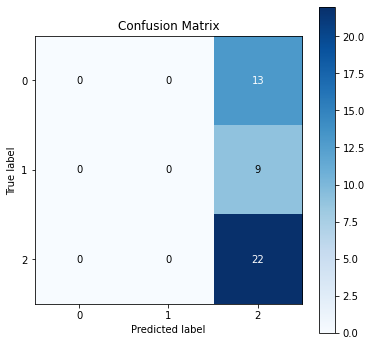

In [ ]:
skplt.metrics.plot_confusion_matrix(true, predicted, figsize=(6,6))

In [ ]:
classification_rep = sklearn.metrics.classification_report(true,predicted,target_names=['negative', 'neutral', 'positive'])
print(classification_rep)

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        12
     neutral       0.68      1.00      0.81        30
    positive       0.00      0.00      0.00         2

    accuracy                           0.68        44
   macro avg       0.23      0.33      0.27        44
weighted avg       0.46      0.68      0.55        44



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
sklearn.metrics.accuracy_score(true,predicted)

0.6818181818181818

### 2.1 BERT Model with FinBERT Architecture & Trained Weights - WITHOUT Stop Words

#### Create a BERT Model with FinBERT Arch

In [ ]:
# Training and Test Datasets from Model 1.2
  # train_wo_sw_df
  # eval_wo_sw_df

In [ ]:
finBERT_model = ClassificationModel('bert', 'ipuneetrathore/bert-base-cased-finetuned-finBERT', num_labels=3, args={'reprocess_input_data': True, 'overwrite_output_dir': True},use_cuda=True)

In [ ]:
finBERT_model.train_model(train_wo_sw_df)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:380: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


(40, 1.5310955822467804)

In [ ]:
result, model_outputs, wrong_predictions = finBERT_model.eval_model(eva_wo_sw_df)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:901: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


#### BERT Model with FinBERT Arch Results

In [ ]:
print(result)
model_outputs[:5]

{'mcc': 0.03405355158753309, 'eval_loss': 0.9395012557506561}


array([[ 0.31640625,  1.15722656, -1.63769531],
       [ 0.65722656,  0.68066406, -1.30371094],
       [ 0.39526367,  1.02734375, -1.56347656],
       [ 0.42016602,  1.04296875, -1.5859375 ],
       [ 0.42626953,  1.01171875, -1.55957031]])

In [ ]:
true = eva_wo_sw_df['label'].tolist()
predicted = []
for arr in model_outputs:
    predicted.append(np.argmax(arr))

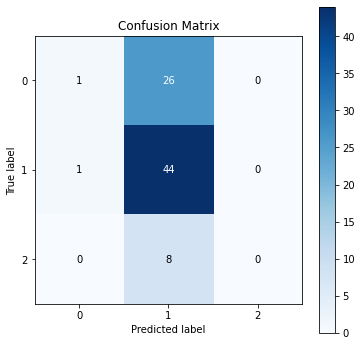

In [ ]:
skplt.metrics.plot_confusion_matrix(true, predicted, figsize=(6,6))

In [ ]:
classification_rep = sklearn.metrics.classification_report(true,predicted,target_names=['negative', 'neutral', 'positive'])
print(classification_rep)

              precision    recall  f1-score   support

    negative       0.50      0.04      0.07        27
     neutral       0.56      0.98      0.72        45
    positive       0.00      0.00      0.00         8

    accuracy                           0.56        80
   macro avg       0.35      0.34      0.26        80
weighted avg       0.49      0.56      0.43        80



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 2.2 BERT Model with FinBERT Architecture & Trained Weights - WITHOUT Stop Words - Minutes Only


#### Create a BERT Model with FinBERT Arch - Minutes Only



In [ ]:
# Training and Test Datasets from Model 1.3
  # train_mins_wo_sw_df.shape
  # eva_mins_wo_sw_df.shape

In [ ]:
finBERT_model2 = ClassificationModel('bert', 'ipuneetrathore/bert-base-cased-finetuned-finBERT', num_labels=3, args={'reprocess_input_data': True, 'overwrite_output_dir': True},use_cuda=True)

In [ ]:
finBERT_model2.train_model(train_mins_wo_sw_df)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:380: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


(22, 1.993745131926103)

In [ ]:
result, model_outputs, wrong_predictions = finBERT_model2.eval_model(eva_mins_wo_sw_df)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:901: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


#### BERT Model with FinBERT Arch Results - Minutes Only



In [ ]:
print(result)
model_outputs[:5]

{'mcc': 0.08551896437954244, 'eval_loss': 0.9053101440270742}


array([[-0.04641724,  0.63330078,  0.02513123],
       [ 0.56689453,  0.42602539, -0.56054688],
       [ 0.32397461,  0.60107422, -0.42016602],
       [ 0.14453125,  0.59960938, -0.24584961],
       [ 0.39331055,  0.55908203, -0.46948242]])

In [ ]:
true = eva_mins_wo_sw_df['label'].tolist()
predicted = []
for arr in model_outputs:
    predicted.append(np.argmax(arr))

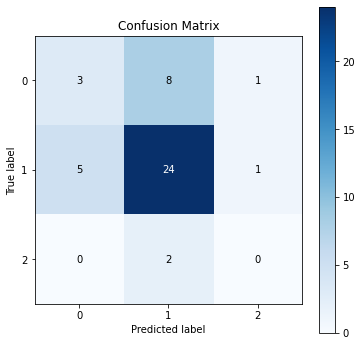

In [ ]:
skplt.metrics.plot_confusion_matrix(true, predicted, figsize=(6,6))

In [ ]:
classification_rep = sklearn.metrics.classification_report(true,predicted,target_names=['negative', 'neutral', 'positive'])
print(classification_rep)

              precision    recall  f1-score   support

    negative       0.38      0.25      0.30        12
     neutral       0.71      0.80      0.75        30
    positive       0.00      0.00      0.00         2

    accuracy                           0.61        44
   macro avg       0.36      0.35      0.35        44
weighted avg       0.58      0.61      0.59        44



### 2.1 BERT Model with Fine Tunning - Minutes Only
https://simpletransformers.ai/docs/usage/

#### Create a BERT Model with Fine Tunning - Minutes Only



In [ ]:
# Training and Test Datasets from Model 1.3
  # train_mins_wo_sw_df.shape
  # eva_mins_wo_sw_df.shape

In [ ]:
model_args = ClassificationArgs()
model_args.train_batch_size = 2 #evalution batch size
model_args.gradient_accumulation_steps = 8 #The number of training steps to execute before
                                          #performing a optimizer.step(). Effectively increases 
                                          #the training batch size while sacrificing training time 
                                          #to lower memory consumption.
model_args.learning_rate = 3e-5 #learning rate for training
model_args.num_train_epochs = 10 #number of epochs the model will be trained for
model_args.overwrite_output_dir = True #if True, the trained model will be saved to the output_dir
                                        #and will overwrite existing saed models in the same directory
model_args.max_seq_length = 512 #max sequence length the model will support

In [ ]:
BERT_model_tuned = ClassificationModel('bert', 'bert-base-uncased', num_labels=3, args=model_args,use_cuda=True)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
BERT_model_tuned.train_model(train_mins_wo_sw_df)
train_mins_wo_sw_df eva_mins_wo_sw_df

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:380: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


(100, 0.9074697407335043)

In [ ]:
pred_bert, out_bert = BERT_model_tuned.predict(eva_mins_wo_sw_df['text'].values)

acc_bert = accuracy_score(eva_mins_wo_sw_df['label'].to_numpy(), pred_bert)
f1_bert = f1_score(eva_mins_wo_sw_df['label'].to_numpy(), pred_bert, average='micro')

print("Accuracy score -->", acc_bert)
print("F1 score -->", f1_bert)


Accuracy score --> 0.6818181818181818
F1 score --> 0.6818181818181818


In [ ]:
result, model_outputs, wrong_predictions = BERT_model_tuned.eval_model(eva_mins_wo_sw_df)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:901: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [ ]:
print(result)
model_outputs[:5]

{'mcc': 0.0, 'eval_loss': 0.7592720886071523}


array([[ 0.08001709,  1.0078125 , -1.47949219],
       [ 0.14331055,  0.97900391, -1.51074219],
       [ 0.09130859,  0.9921875 , -1.47265625],
       [ 0.18322754,  0.90039062, -1.46777344],
       [ 0.28466797,  0.90576172, -1.51171875]])

In [ ]:
true = eva_mins_wo_sw_df['label'].tolist()
predicted = []
for arr in model_outputs:
    predicted.append(np.argmax(arr))

In [ ]:
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(true , predicted)
cm

array([[ 0, 12,  0],
       [ 0, 30,  0],
       [ 0,  2,  0]])

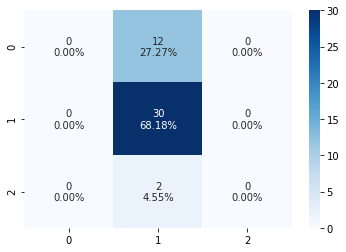

In [ ]:
# cm = confusion_matrix(pred_bert, test_x_y['labels'].to_numpy())

#group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(3,3)
sns.heatmap(cm, annot=labels, fmt="", cmap='Blues')
plt.show()

In [ ]:
classification_rep = sklearn.metrics.classification_report(true,predicted,target_names=['negative', 'neutral', 'positive'])
print(classification_rep)

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        12
     neutral       0.68      1.00      0.81        30
    positive       0.00      0.00      0.00         2

    accuracy                           0.68        44
   macro avg       0.23      0.33      0.27        44
weighted avg       0.46      0.68      0.55        44



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
sklearn.metrics.accuracy_score(true,predicted)

0.6818181818181818

### BERT Model #2
https://simpletransformers.ai/docs/usage/

In [ ]:
model_args = ClassificationArgs()
model_args.train_batch_size = 2 #evalution batch size
model_args.gradient_accumulation_steps = 8 #The number of training steps to execute before
                                          #performing a optimizer.step(). Effectively increases 
                                          #the training batch size while sacrificing training time 
                                          #to lower memory consumption.
model_args.learning_rate = 3e-5 #learning rate for training
model_args.num_train_epochs = 20 #number of epochs the model will be trained for
model_args.overwrite_output_dir = True #if True, the trained model will be saved to the output_dir
                                        #and will overwrite existing saed models in the same directory
model_args.max_seq_length = 512 #max sequence length the model will support

In [ ]:
BERT_model_2 = ClassificationModel('bert', 'bert-base-uncased', num_labels=3, args=model_args,use_cuda=True)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
BERT_model_2.train_model(train4_df)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:380: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


(200, 0.46899604973790704)

In [ ]:
dpred_bert, out_bert = BERT_model_2.predict(eval4_df['text'].values)

acc_bert = accuracy_score(eval4_df['label'].to_numpy(), pred_bert)
f1_bert = f1_score(eval4_df['label'].to_numpy(), pred_bert, average='micro')

print("Accuracy score -->", acc_bert)
print("F1 score -->", f1_bert)


Accuracy score --> 0.6590909090909091
F1 score --> 0.6590909090909091


In [ ]:
result, model_outputs, wrong_predictions = BERT_model_2.eval_model(eval4_df)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:901: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


In [ ]:
print(result)
model_outputs

{'mcc': 0.07476455895471043, 'eval_loss': 1.8045362134774525}


array([[-2.19921875e+00,  4.09375000e+00, -1.37890625e+00],
       [-2.05468750e+00,  3.46875000e+00, -1.07519531e+00],
       [ 1.84765625e+00, -1.09277344e+00, -1.38085938e+00],
       [-2.15429688e+00,  3.32617188e+00, -6.92871094e-01],
       [-1.84570312e+00,  3.79492188e+00, -1.85937500e+00],
       [-2.31054688e+00,  3.33007812e+00, -1.87988281e-01],
       [-1.94140625e+00,  3.84765625e+00, -1.81445312e+00],
       [-2.15625000e+00,  3.74414062e+00, -1.41308594e+00],
       [-1.90429688e+00,  2.91406250e+00, -2.14843750e-01],
       [ 3.08789062e+00, -2.15625000e+00, -1.59277344e+00],
       [-2.14453125e+00,  3.87500000e+00, -1.57421875e+00],
       [-1.90234375e+00,  3.91015625e+00, -1.82324219e+00],
       [-7.79151917e-04,  8.28125000e-01, -3.54492188e-01],
       [ 2.77343750e+00, -1.88574219e+00, -1.71582031e+00],
       [-1.89941406e+00,  3.83984375e+00, -1.52148438e+00],
       [-2.08984375e+00,  3.95117188e+00, -1.53222656e+00],
       [-2.03515625e+00,  4.00390625e+00

In [ ]:
true = eval4_df['label'].tolist()
predicted = []
for arr in model_outputs:
    predicted.append(np.argmax(arr))

In [ ]:
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

cm2 = confusion_matrix(true , predicted)
cm2

array([[ 3, 10,  0],
       [ 3, 23,  3],
       [ 1,  1,  0]])

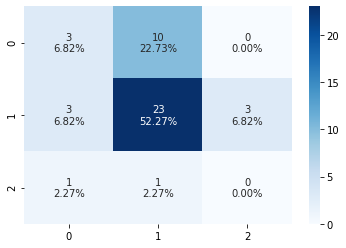

In [ ]:
# cm = confusion_matrix(pred_bert, test_x_y['labels'].to_numpy())

#group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cm2.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm2.flatten()/np.sum(cm2)]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(3,3)
sns.heatmap(cm2, annot=labels, fmt="", cmap='Blues')
plt.show()

In [ ]:
classification_rep = sklearn.metrics.classification_report(true,predicted,target_names=['negative', 'neutral', 'positive'])
print(classification_rep)

              precision    recall  f1-score   support

    negative       0.43      0.23      0.30        13
     neutral       0.68      0.79      0.73        29
    positive       0.00      0.00      0.00         2

    accuracy                           0.59        44
   macro avg       0.37      0.34      0.34        44
weighted avg       0.57      0.59      0.57        44



In [ ]:
sklearn.metrics.accuracy_score(true,predicted)

0.5909090909090909

### BERT Model #1
### Standard with score_LM as True Label

In [ ]:
# BERT_model = ClassificationModel('bert', 'bert-base-uncased', num_labels=3, args={'reprocess_input_data': True, 'overwrite_output_dir': True},use_cuda=False)
# finBERT_model = ClassificationModel('bert', 'ipuneetrathore/bert-base-cased-finetuned-finBERT', num_labels=3, args={'reprocess_input_data': True, 'overwrite_output_dir': True},use_cuda=True)
BERT_model = ClassificationModel('bert', 'bert-base-cased', num_labels=3, args={'reprocess_input_data': True, 'overwrite_output_dir': True},use_cuda=True)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [ ]:
BERT_model.train_model(train_df)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:380: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


(40, 1.0274206504225731)

In [ ]:
result, model_outputs, wrong_predictions = BERT_model.eval_model(eval_df)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:901: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


In [ ]:
print(result)
model_outputs

In [ ]:
true = eval_df['label'].tolist()
predicted = []
for arr in model_outputs:
    predicted.append(np.argmax(arr))

In [ ]:
import sklearn
from sklearn.metrics import accuracy_score, f1_score,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = sklearn.metrics.confusion_matrix(true , predicted)
cm

array([[29,  1,  1],
       [14, 11,  0],
       [10, 12,  2]])

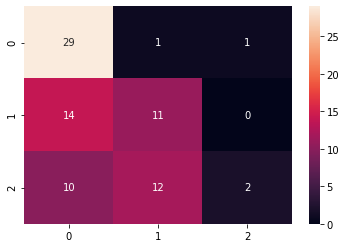

In [ ]:
df_cm = pd.DataFrame(cm, range(3), range(3))

sns.heatmap(df_cm, annot=True) 
plt.show()

In [ ]:
classification_rep = sklearn.metrics.classification_report(true,predicted,target_names=['negative', 'neutral', 'positive'])
print(classification_rep)

              precision    recall  f1-score   support

    negative       0.55      0.94      0.69        31
     neutral       0.46      0.44      0.45        25
    positive       0.67      0.08      0.15        24

    accuracy                           0.53        80
   macro avg       0.56      0.49      0.43        80
weighted avg       0.56      0.53      0.45        80



In [ ]:
sklearn.metrics.accuracy_score(true,predicted)

0.525


```
# This is formatted as code
```

### BERT Model #2
### Standard with score_FED as True Label

In [ ]:
# BERT_model = ClassificationModel('bert', 'bert-base-uncased', num_labels=3, args={'reprocess_input_data': True, 'overwrite_output_dir': True},use_cuda=False)
# finBERT_model = ClassificationModel('bert', 'ipuneetrathore/bert-base-cased-finetuned-finBERT', num_labels=3, args={'reprocess_input_data': True, 'overwrite_output_dir': True},use_cuda=True)
BERT_model2 = ClassificationModel('bert', 'bert-base-cased', num_labels=3, args={'reprocess_input_data': True, 'overwrite_output_dir': True},use_cuda=True)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [ ]:
BERT_model2.train_model(train_df)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:380: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


(40, 1.1091869607567788)

In [ ]:
result, model_outputs, wrong_predictions = BERT_model2.eval_model(eval_df)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:901: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


In [ ]:
print(result)
model_outputs

{'mcc': -0.057423705234817816, 'eval_loss': 1.1078078746795654}


array([[-0.06634521, -0.34350586,  0.24914551],
       [-0.15148926, -0.40356445,  0.25415039],
       [-0.15869141, -0.41259766,  0.25830078],
       [-0.24926758, -0.48999023,  0.28833008],
       [-0.08868408, -0.37744141,  0.22729492],
       [-0.08752441, -0.38378906,  0.24267578],
       [-0.18164062, -0.42358398,  0.26806641],
       [-0.15478516, -0.41552734,  0.2668457 ],
       [-0.13769531, -0.39550781,  0.24328613],
       [-0.17663574, -0.41430664,  0.26269531],
       [-0.14660645, -0.40112305,  0.33007812],
       [-0.09857178, -0.37231445,  0.2232666 ],
       [-0.37988281, -0.46606445,  0.18884277],
       [-0.05163574, -0.32104492,  0.22644043],
       [-0.25610352, -0.4699707 ,  0.28320312],
       [-0.09771729, -0.36474609,  0.23510742],
       [-0.23803711, -0.47094727,  0.31103516],
       [-0.18334961, -0.43969727,  0.27661133],
       [-0.09875488, -0.36450195,  0.23913574],
       [ 0.11254883, -0.34399414,  0.3503418 ],
       [-0.14855957, -0.40917969,  0.266

In [ ]:
true = eval_df['label'].tolist()
predicted = []
for arr in model_outputs:
    predicted.append(np.argmax(arr))

In [ ]:
import sklearn
from sklearn.metrics import accuracy_score, f1_score,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = sklearn.metrics.confusion_matrix(true , predicted)
cm

array([[ 0,  1, 28],
       [ 0,  0, 22],
       [ 0,  1, 28]])

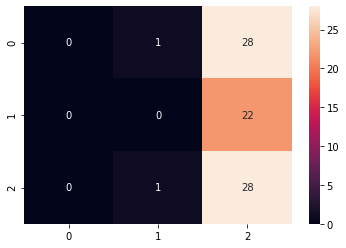

In [ ]:
df_cm = pd.DataFrame(cm, range(3), range(3))

sns.heatmap(df_cm, annot=True) 
plt.show()

In [ ]:
classification_rep = sklearn.metrics.classification_report(true,predicted,target_names=['negative', 'neutral', 'positive'])
print(classification_rep)

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        29
     neutral       0.00      0.00      0.00        22
    positive       0.36      0.97      0.52        29

    accuracy                           0.35        80
   macro avg       0.12      0.32      0.17        80
weighted avg       0.13      0.35      0.19        80



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
sklearn.metrics.accuracy_score(true,predicted)

0.35


```
# This is formatted as code
```

### BERT Model #3
### Minute Data Only
### Standard with score_FED as True Label

In [ ]:
FOMC_minute_model_data_df = FOMC_minute_df[['document_data', 'score_FED']] 

In [ ]:
train_3, eva_3 = train_test_split(FOMC_minute_model_data_df, test_size = 0.2)

In [ ]:
print('X_train.shape',train_3.shape)
print('X_val.shape',eva_3.shape)
train_3.head()

X_train.shape (173, 2)
X_val.shape (44, 2)


,document_data,score_FED
355,longer run objective but longer term inflation...,1
203,slowing in the pace of the expansion as a reas...,2
349,in the economy s estimated potential growth of...,0
271,high household debt burdens homebuilding was f...,2
329,was expected to remain low in the near term in...,1


In [ ]:
train3_df = pd.DataFrame({
    'text': train_3['document_data'],
    'label': train_3['score_FED']
})

eval3_df = pd.DataFrame({
    'text': eva_3['document_data'],
    'label': eva_3['score_FED']
})

print(train_df.shape)
print(eval_df.shape)
train_df.head()
# type(train_df)

(320, 2)
(80, 2)


,text,label
255,fairly robust construction of multifamily hous...,0
384,response to the previous backup in residential...,2
38,unemployment rate remains elevated household s...,0
319,recent indicators including strong job gains p...,1
370,prospects for productivity growth and the econ...,2


In [ ]:
# BERT_model = ClassificationModel('bert', 'bert-base-uncased', num_labels=3, args={'reprocess_input_data': True, 'overwrite_output_dir': True},use_cuda=False)
# finBERT_model = ClassificationModel('bert', 'ipuneetrathore/bert-base-cased-finetuned-finBERT', num_labels=3, args={'reprocess_input_data': True, 'overwrite_output_dir': True},use_cuda=True)
BERT_model3 = ClassificationModel('bert', 'bert-base-cased', num_labels=3, args={'reprocess_input_data': True, 'overwrite_output_dir': True},use_cuda=True)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [ ]:
BERT_model3.train_model(train3_df)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:380: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


(22, 1.1658886779438367)

In [ ]:
result, model_outputs, wrong_predictions = BERT_model3.eval_model(eval3_df)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:901: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


In [ ]:
print(result)
model_outputs

{'mcc': 0.0, 'eval_loss': 1.0709508955478668}


array([[-0.06903076, -0.36352539,  0.23852539],
       [-0.12597656, -0.40283203,  0.2512207 ],
       [-0.27392578, -0.48950195,  0.2956543 ],
       [-0.05865479, -0.34277344,  0.23510742],
       [-0.1697998 , -0.41650391,  0.25439453],
       [-0.30517578, -0.49072266,  0.27832031],
       [-0.07751465, -0.3581543 ,  0.2479248 ],
       [-0.15686035, -0.40917969,  0.24389648],
       [-0.27758789, -0.47265625,  0.32495117],
       [-0.1862793 , -0.42504883,  0.24694824],
       [-0.12597656, -0.39160156,  0.25170898],
       [-0.25097656, -0.47631836,  0.2878418 ],
       [-0.07006836, -0.34155273,  0.22619629],
       [-0.13439941, -0.40893555,  0.24975586],
       [-0.15246582, -0.41015625,  0.2565918 ],
       [-0.18664551, -0.42797852,  0.26489258],
       [-0.17102051, -0.41381836,  0.26953125],
       [-0.17907715, -0.43676758,  0.25732422],
       [-0.06677246, -0.33178711,  0.22155762],
       [-0.21484375, -0.4465332 ,  0.26757812],
       [-0.2244873 , -0.44946289,  0.264

In [ ]:
true = eval3_df['label'].tolist()
predicted = []
for arr in model_outputs:
    predicted.append(np.argmax(arr))

In [ ]:
import sklearn
from sklearn.metrics import accuracy_score, f1_score,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = sklearn.metrics.confusion_matrix(true , predicted)
cm

array([[ 2,  0, 12],
       [ 0,  0, 11],
       [ 0,  0, 19]])

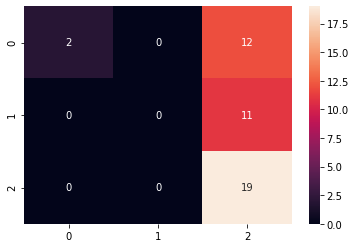

In [ ]:
df_cm = pd.DataFrame(cm, range(3), range(3))

sns.heatmap(df_cm, annot=True) 
plt.show()

In [ ]:
classification_rep = sklearn.metrics.classification_report(true,predicted,target_names=['negative', 'neutral', 'positive'])
print(classification_rep)

              precision    recall  f1-score   support

    negative       1.00      0.14      0.25        14
     neutral       0.00      0.00      0.00        11
    positive       0.45      1.00      0.62        19

    accuracy                           0.48        44
   macro avg       0.48      0.38      0.29        44
weighted avg       0.51      0.48      0.35        44



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
sklearn.metrics.accuracy_score(true,predicted)

0.4772727272727273

In [ ]:
# BERT_model = ClassificationModel('bert', 'bert-base-uncased', num_labels=3, args={'reprocess_input_data': True, 'overwrite_output_dir': True},use_cuda=False)
finBERT_model = ClassificationModel('bert', 'ipuneetrathore/bert-base-cased-finetuned-finBERT', num_labels=3, args={'reprocess_input_data': True, 'overwrite_output_dir': True},use_cuda=True)
# BERT_model4 = ClassificationModel('bert', 'bert-base-cased', num_labels=3, args={'reprocess_input_data': True, 'overwrite_output_dir': True},use_cuda=True)


In [ ]:
finBERT_model.train_model(train4_df)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:380: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


(22, 2.6922677863727915)

In [ ]:
result, model_outputs, wrong_predictions = finBERT_model.eval_model(eval4_df)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:901: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


In [ ]:
print(result)
model_outputs

{'mcc': 0.04458205674487168, 'eval_loss': 0.9578025241692861}


array([[ 8.91113281e-01,  4.90478516e-01, -1.02148438e+00],
       [ 6.45996094e-01,  9.37988281e-01, -1.19238281e+00],
       [-4.96582031e-01,  5.97167969e-01,  6.19628906e-01],
       [ 6.82128906e-01,  9.35546875e-01, -1.33593750e+00],
       [ 8.92578125e-01,  3.47412109e-01, -7.42675781e-01],
       [ 9.29199219e-01,  4.91699219e-01, -9.30664062e-01],
       [ 8.40820312e-01,  4.91210938e-01, -8.80371094e-01],
       [ 7.43164062e-01,  6.87011719e-01, -9.95605469e-01],
       [ 9.59960938e-01,  4.81689453e-01, -1.09179688e+00],
       [ 4.38476562e-01,  1.42968750e+00, -1.70214844e+00],
       [ 9.07421112e-04,  6.41601562e-01, -6.98852539e-02],
       [ 4.33959961e-02,  1.12792969e+00, -7.33398438e-01],
       [ 8.70605469e-01,  3.84765625e-01, -6.98730469e-01],
       [ 4.32617188e-01,  1.07421875e+00, -1.25878906e+00],
       [ 9.61914062e-01,  3.85742188e-01, -9.32617188e-01],
       [ 7.77832031e-01,  6.28417969e-01, -9.51660156e-01],
       [ 7.95410156e-01,  7.81250000e-01

In [ ]:
true = eval4_df['label'].tolist()
predicted = []
for arr in model_outputs:
    predicted.append(np.argmax(arr))

In [ ]:
import sklearn
from sklearn.metrics import accuracy_score, f1_score,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = sklearn.metrics.confusion_matrix(true , predicted)
cm

array([[ 9,  3,  1],
       [20,  9,  0],
       [ 2,  0,  0]])

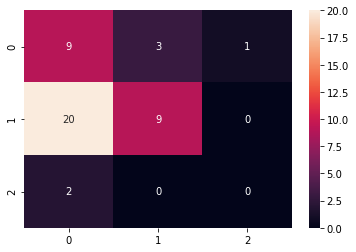

In [ ]:
df_cm = pd.DataFrame(cm, range(3), range(3))

sns.heatmap(df_cm, annot=True) 
plt.show()

In [ ]:
classification_rep = sklearn.metrics.classification_report(true,predicted,target_names=['negative', 'neutral', 'positive'])
print(classification_rep)

              precision    recall  f1-score   support

    negative       0.29      0.69      0.41        13
     neutral       0.75      0.31      0.44        29
    positive       0.00      0.00      0.00         2

    accuracy                           0.41        44
   macro avg       0.35      0.33      0.28        44
weighted avg       0.58      0.41      0.41        44



In [ ]:
sklearn.metrics.accuracy_score(true,predicted)

0.4090909090909091


```
# This is formatted as code
```

### BERT Model #4
### Minute Data Only
### Standard with score_market as True Label

In [ ]:
FOMC_minute_model_data_df_2 = FOMC_minute_df[['document_data', 'score_market']] 

In [ ]:
train_4, eva_4 = train_test_split(FOMC_minute_model_data_df_2, test_size = 0.2)

In [ ]:
print('X_train.shape',train_4.shape)
print('X_val.shape',eva_4.shape)
train_4.head()

X_train.shape (173, 2)
X_val.shape (44, 2)


,document_data,score_market
225,policy assessments are described in the summar...,1
42,2 and mr greenlee 2 associate directors divisi...,0
369,of favorable consumer sentiment that in turn u...,2
230,in inventory investment from the clearly unsus...,0
394,with ongoing efforts to improve productivity w...,1


In [ ]:
train4_df = pd.DataFrame({
    'text': train_4['document_data'],
    'label': train_4['score_market']
})

eval4_df = pd.DataFrame({
    'text': eva_4['document_data'],
    'label': eva_4['score_market']
})

print(train4_df.shape)
print(eval4_df.shape)
train4_df.head()
# type(train_df)

(173, 2)
(44, 2)


,text,label
225,policy assessments are described in the summar...,1
42,2 and mr greenlee 2 associate directors divisi...,0
369,of favorable consumer sentiment that in turn u...,2
230,in inventory investment from the clearly unsus...,0
394,with ongoing efforts to improve productivity w...,1


In [ ]:
# BERT_model = ClassificationModel('bert', 'bert-base-uncased', num_labels=3, args={'reprocess_input_data': True, 'overwrite_output_dir': True},use_cuda=False)
# finBERT_model = ClassificationModel('bert', 'ipuneetrathore/bert-base-cased-finetuned-finBERT', num_labels=3, args={'reprocess_input_data': True, 'overwrite_output_dir': True},use_cuda=True)
BERT_model4 = ClassificationModel('bert', 'bert-base-cased', num_labels=3, args={'reprocess_input_data': True, 'overwrite_output_dir': True},use_cuda=True)


404 Client Error: Not Found for url: https://huggingface.co/bert-base-ucased/resolve/main/config.json


OSError: ignored

In [ ]:
BERT_model4.train_model(train4_df)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:380: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


(22, 0.8725902844559063)

In [ ]:
result, model_outputs, wrong_predictions = BERT_model4.eval_model(eval4_df)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:901: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [ ]:
print(result)
model_outputs

{'mcc': 0.0, 'eval_loss': 0.8141382237275442}


array([[ 0.16479492,  0.94091797, -1.38085938],
       [ 0.19604492,  0.93164062, -1.34667969],
       [ 0.15014648,  0.94628906, -1.37988281],
       [ 0.16491699,  0.9453125 , -1.38378906],
       [ 0.17492676,  0.95263672, -1.34863281],
       [ 0.17773438,  0.95507812, -1.34863281],
       [ 0.17919922,  0.96044922, -1.36035156],
       [ 0.17700195,  0.93359375, -1.36523438],
       [ 0.17553711,  0.95166016, -1.33886719],
       [ 0.14025879,  0.89550781, -1.39257812],
       [ 0.1907959 ,  0.97021484, -1.33886719],
       [ 0.19104004,  0.92626953, -1.34375   ],
       [ 0.15612793,  0.94677734, -1.37011719],
       [ 0.17431641,  0.92041016, -1.36425781],
       [ 0.16540527,  0.96337891, -1.375     ],
       [ 0.17077637,  0.95361328, -1.36035156],
       [ 0.16577148,  0.93945312, -1.34765625],
       [ 0.19128418,  0.95800781, -1.36132812],
       [ 0.19799805,  0.96044922, -1.3203125 ],
       [ 0.12902832,  0.94677734, -1.37597656],
       [ 0.18188477,  0.92236328, -1.362

In [ ]:
true = eval4_df['label'].tolist()
predicted = []
for arr in model_outputs:
    predicted.append(np.argmax(arr))

In [ ]:
import sklearn
from sklearn.metrics import accuracy_score, f1_score,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = sklearn.metrics.confusion_matrix(true , predicted)
cm

array([[ 0, 13,  0],
       [ 0, 29,  0],
       [ 0,  2,  0]])

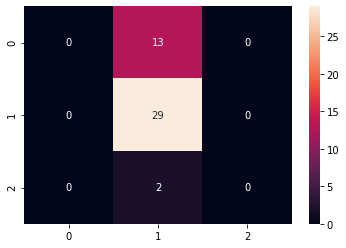

In [ ]:
df_cm = pd.DataFrame(cm, range(3), range(3))

sns.heatmap(df_cm, annot=True) 
plt.show()

In [ ]:
classification_rep = sklearn.metrics.classification_report(true,predicted,target_names=['negative', 'neutral', 'positive'])
print(classification_rep)

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        13
     neutral       0.66      1.00      0.79        29
    positive       0.00      0.00      0.00         2

    accuracy                           0.66        44
   macro avg       0.22      0.33      0.26        44
weighted avg       0.43      0.66      0.52        44



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
sklearn.metrics.accuracy_score(true,predicted)

0.6590909090909091